In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
newDB = automap_base()

# reflect the tables
newDB.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
newDB.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = newDB.classes.measurement
station = newDB.classes.station

In [11]:
# Create our session (link) from Python to the DB
ourSession = Session(engine)

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
recent_date = (ourSession.query(measurement.date)
              .order_by(measurement.date.desc())
               .first())
recent_date = list(np.ravel(recent_date))[0]

recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')

recent_date

datetime.datetime(2017, 8, 23, 0, 0)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

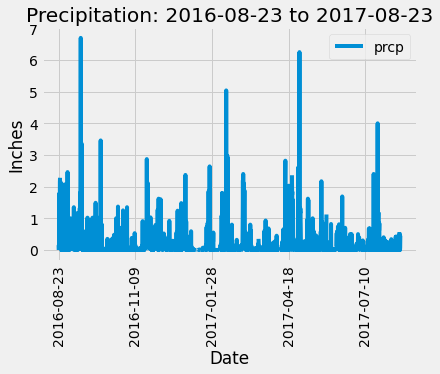

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# utilize the recent_date calculated above

# Calculate the date one year from the last date in data set.
recent_year = int(dt.datetime.strftime(recent_date, '%Y'))
recent_month = int(dt.datetime.strftime(recent_date, '%m'))
recent_day = int(dt.datetime.strftime(recent_date, '%d'))

year_before_latest = dt.date(recent_year, recent_month, recent_day) - dt.timedelta(days=366)
#year_before_latest 


# Perform a query to retrieve the data and precipitation scores
precip_scores = (ourSession.query(measurement.date, measurement.prcp)
                .filter(measurement.date > year_before_latest)
                .order_by(measurement.date)
                .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_DF = pd.DataFrame(precip_scores)
precip_DF = precip_DF.set_index('date')

# Sort the dataframe by date
precip_DF = precip_DF.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_DF.plot(title="Precipitation: 2016-08-23 to 2017-08-23",
              xlabel="Date", ylabel="Inches")
plt.xticks(rotation=90)



In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_DF.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number stations in the dataset
count_stations = ourSession.query(station).count()
print(f"# of Stations: {count_stations}")

# of Stations: 9


In [48]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
count_stations = (ourSession.query(measurement.station, func.count(measurement.station))
.group_by(measurement.station)
.order_by(func.count(measurement.station).desc())
.all())

count_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the most active station id from the previous query:

station_id = count_stations[0][0]

most_active_station = (ourSession.query(station.name)
                      .filter_by(station = station_id))

most_active_station = most_active_station[0][0]
print(f"The most active station is {station_id}: {most_active_station}.")

The most active station is USC00519281: WAIHEE 837.5, HI US.


In [59]:
#calculate the lowest temperature, 
lowest_temp = (ourSession.query(func.min(measurement.tobs))
              .filter(measurement.station == station_id))

lowest_temp = '{0:.3}'.format(lowest_temp[0][0])

degree_sign = u'\N{DEGREE SIGN}'
print(f"The Lowest temperature is {lowest_temp}{degree_sign} Farenheit.")


The Lowest temperature is 54.0° Farenheit.


In [61]:
#highest temperature, 

highest_temp = (ourSession.query(func.max(measurement.tobs))
               .filter(measurement.station == station_id))

highest_temp = '{0:.3}'.format(highest_temp[0][0])

print(f"The Highest temperature is {highest_temp}{degree_sign} Farenheit.")

The Highest temperature is 85.0° Farenheit.


In [62]:
#and average temperature.
average_temp = (ourSession.query(func.avg(measurement.tobs))
               .filter(measurement.station == station_id))

average_temp = '{0:.3}'.format(average_temp[0][0])

print(f"The Average temperature is {average_temp}{degree_sign} Farenheit.")


The Average temperature is 71.7° Farenheit.


<AxesSubplot:title={'center':'Previous 12 Months TOBS'}, ylabel='Frequency'>

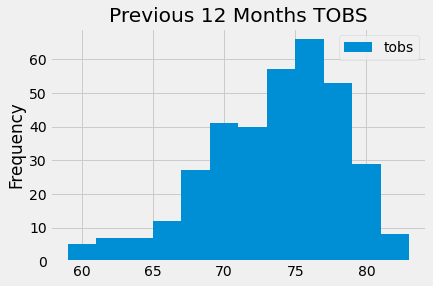

In [74]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temporary_data = (ourSession.query(measurement.date, measurement.tobs)
            .filter(measurement.date > year_before_latest)
            .filter(measurement.station == station_id)
            .order_by(measurement.date)
            .all())

# put query object into the dataframe
temporary_DF = pd.DataFrame(temporary_data)
temporary_DF = temporary_DF.set_index('date')

# sort ascending by date
temporary_DF = temporary_DF.sort_index(ascending=True)

# using Pandas for histogram
temporary_DF.plot(kind='hist', bins=12, title = "Previous 12 Months TOBS",
                 xlabel="Temperature", ylabel="Frequency")


# Close session

In [76]:
# Close Session
ourSession.close()